# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

1)Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

2)Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [13]:
# загрузим все необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [14]:
# загрузим labels.csv
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.sample(5)

,file_name,real_age
2996,002996.jpg,47
6879,006890.jpg,1
6740,006747.jpg,13
3509,003509.jpg,16
764,000764.jpg,16


In [15]:
# оценим размер выборки
labels.shape

(7591, 2)

In [16]:
# пропуски
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [17]:
# дубликаты
labels.duplicated().sum()

0

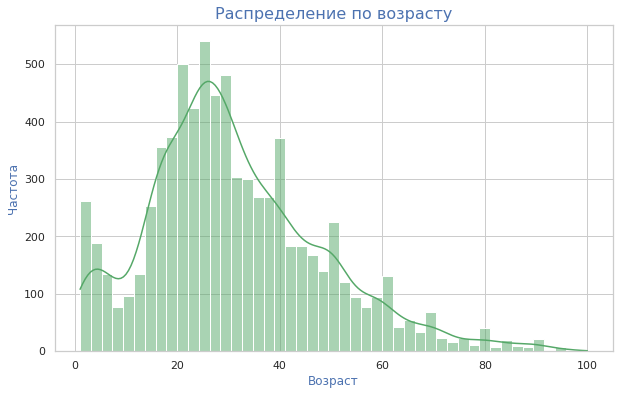

In [18]:
# построим график распределения возраста в выборке
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.histplot(labels['real_age'], kde=True, color='g')
plt.xlabel('Возраст', fontsize=12, color='b')
plt.ylabel('Частота', fontsize=12, color='b')
plt.title('Распределение по возрасту', fontsize=16, color='b')
plt.show()

Как мы можем видеть из графика выше, у нас есть фотографии людей разных возрастов. Однако большинство изображений принадлежит людям в возрасте от 20 до 40 лет.

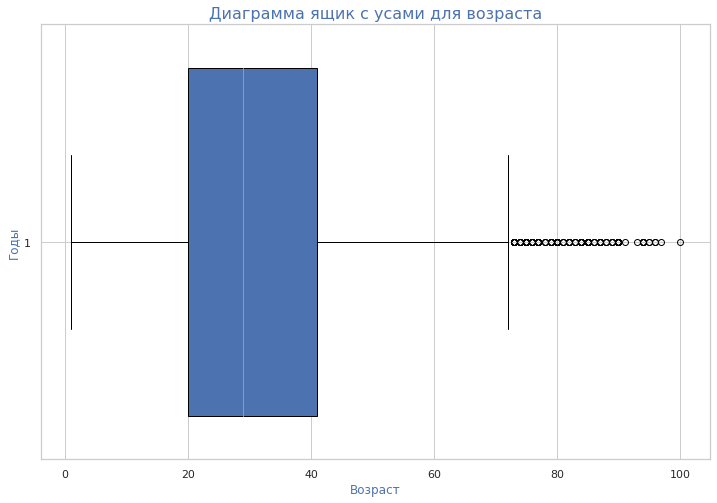

In [31]:
# создадим фигуры и оси
fig, ax = plt.subplots(figsize=(12, 8))

# построим диаграмму ящик с усами
box_plot = ax.boxplot(labels['real_age'], patch_artist=True, vert=False, widths=0.8)

# подписи
ax.set_xlabel('Возраст', fontsize=12, color='b')
ax.set_ylabel('Годы', fontsize=12, color='b')
ax.set_title('Диаграмма ящик с усами для возраста', fontsize=16, color='b')

# сетка
plt.grid(True)

plt.show()

Из диаграммы ящик с усами видно, что в распределении присутствуют выбросы справа - в старшей возрастной категории.

Учитывая тот факт, что количество файлов с изображениями достаточно велико, нужно избегать чтения их всех одновременно, так как это будет сильно потреблять вычислительные ресурсы. Поэтому воспользуемся классом ImageDataGenerator из библиотеки Keras для формирования пакетов с изображениями и метками (например, для классификации) на основе фотографий в каталоге.

In [28]:
# создадим экземпляр генератора данных с изображениями и метками для обучения
train_datagen = ImageDataGenerator(rescale=1./255)

# создадим генератор потока данных из DataFrame, содержащего метки для изображений
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,                           # Используем DataFrame с метками
        directory='/datasets/faces/final_files/',       
        x_col='file_name',                              
        y_col='real_age',                               
        target_size=(224, 224),                     # Размер изображений (ширина, высота)
        batch_size=32,                              # Размер пакета (количество изображений в пакете)
        class_mode='raw',                           # Мод для задачи регрессии (не классификации)
        seed=42                          
                                                   )

Found 7591 validated image filenames.


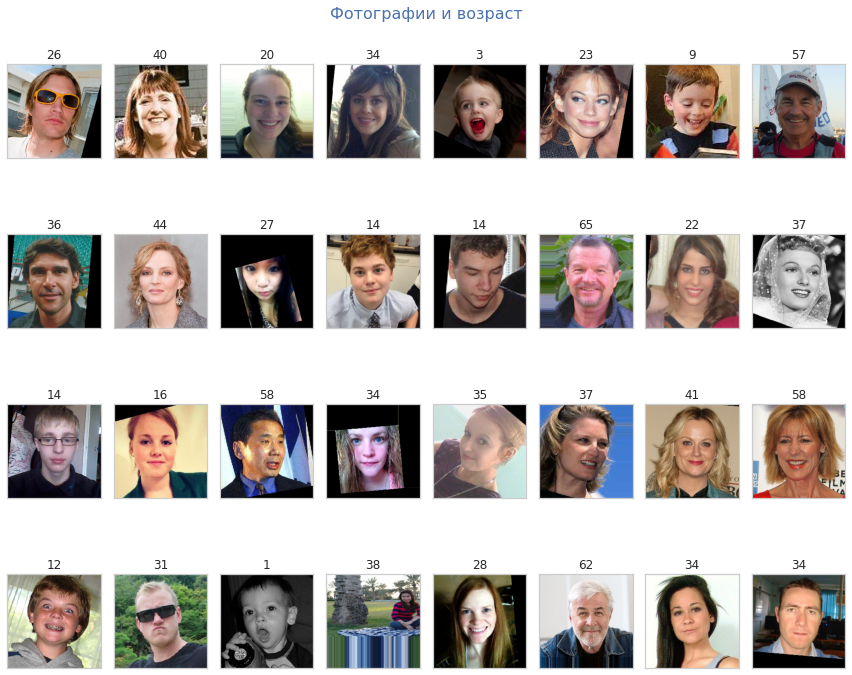

In [34]:
# поличим один пакет изображений и выведем их
features, target = next(train_gen_flow)

# отразить 32 изображения
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
    # уберем оси координат и приблизим изображения друг к другу для более компактного вывода
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Фотографии и возраст',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

### Вывод по разделу

Как мы можем видеть из графика выше, у нас есть фотографии людей разных возрастов. Однако большинство изображений принадлежит людям в возрасте от 20 до 40 лет. Из диаграммы ящик с усами видно, что в распределении присутствуют выбросы справа - в старшей возрастной категории.

Следует отметить, что такое распределение возрастных групп в базе фотографий может влиять на модели  машинного обучения, которые работают с возрастными признаками. Например, у нас есть смещение в сторону фотографий людей среднего возраста, наша модель может быть более точной в определении возраста в этом диапазоне, в то время как ее производительность может быть ниже для других возрастных групп.

Для более сбалансированной модели машинного обучения может быть полезным обратить внимание на сбор большего количества фотографий из разных возрастных групп или использовать методы взвешивания данных, чтобы модель имела более равную возможность обучаться на всех возрастных группах.

Касательно состава фотографий датасета можно заметить следующее:
- размере фотографий 244х244;
- ракурсе фотогарфий анфас, редко встречается 3/4;
- большая часть фотографий цветные и редко встречаются черно-белые;
- все  фотографии центрированы, есть повёрнутрые;
- на фото только лица;
- на некоторых фото можно заметить посторонние предметы, которые могут внести искажения в оценке возраста

## Обучение модели

```python

def load_train(path):
    
    """
    Загрузка тренировочного датасета
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    
    """
    Загрузка тестового датасета
    """
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe = labels,
    directory=path +'/final_files/',
    x_col="file_name",
    y_col="real_age", 
    class_mode="raw", 
    target_size=(224,224), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )

    return test_gen_flow


def create_model(input_shape):
    
    """
    It defines the model
    """
    # используем ResNet50 с заморозкой верхних слоев
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    
    # добавим слои
    # добавление слоя Dropout в нейронную сеть помогает предотвратить переобучение модели
    model.add(Dropout(0.1))
    model.add(GlobalAveragePooling2D())
    
    # добавим лишь один нейрон в выходной слой, так как имеем случай регрессии
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Тренировка модели на заданных параметрах
    """
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model

```

```

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-10-09 20:45:21.186234: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-09 20:45:21.480071: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 10.2865 - mae: 10.2871 - val_loss: 25.3217 - val_mae: 25.3335
Epoch 2/20
178/178 - 38s - loss: 7.2245 - mae: 7.2247 - val_loss: 22.6215 - val_mae: 22.6203
Epoch 3/20
178/178 - 38s - loss: 6.0302 - mae: 6.0302 - val_loss: 17.1399 - val_mae: 17.0905
Epoch 4/20
178/178 - 38s - loss: 5.3155 - mae: 5.3159 - val_loss: 10.2432 - val_mae: 10.2213
Epoch 5/20
178/178 - 47s - loss: 4.8118 - mae: 4.8117 - val_loss: 7.5794 - val_mae: 7.5611
Epoch 6/20
178/178 - 47s - loss: 4.3042 - mae: 4.3043 - val_loss: 6.6880 - val_mae: 6.7217
Epoch 7/20
178/178 - 48s - loss: 3.9004 - mae: 3.9008 - val_loss: 7.6347 - val_mae: 7.6321
Epoch 8/20
178/178 - 47s - loss: 3.7416 - mae: 3.7413 - val_loss: 6.4794 - val_mae: 6.4920
Epoch 9/20
178/178 - 48s - loss: 3.4432 - mae: 3.4431 - val_loss: 6.1295 - val_mae: 6.1339
Epoch 10/20
178/178 - 49s - loss: 3.2460 - mae: 3.2464 - val_loss: 6.5726 - val_mae: 6.5864
Epoch 11/20
178/178 - 50s - loss: 2.9593 - mae: 2.9594 - val_loss: 6.4708 - val_mae: 6.4868
Epoch 12/20
178/178 - 50s - loss: 2.8804 - mae: 2.8801 - val_loss: 6.3271 - val_mae: 6.3447
Epoch 13/20
178/178 - 50s - loss: 2.6644 - mae: 2.6644 - val_loss: 6.0630 - val_mae: 6.0925
Epoch 14/20
178/178 - 50s - loss: 2.5725 - mae: 2.5725 - val_loss: 6.8068 - val_mae: 6.8152
Epoch 15/20
178/178 - 39s - loss: 2.4976 - mae: 2.4977 - val_loss: 6.5801 - val_mae: 6.6027
Epoch 16/20
178/178 - 38s - loss: 2.3581 - mae: 2.3581 - val_loss: 5.7699 - val_mae: 5.7926
Epoch 17/20
178/178 - 38s - loss: 2.3565 - mae: 2.3568 - val_loss: 6.3830 - val_mae: 6.3965
Epoch 18/20
178/178 - 38s - loss: 2.2963 - mae: 2.2962 - val_loss: 6.8693 - val_mae: 6.8667
Epoch 19/20
178/178 - 38s - loss: 2.1621 - mae: 2.1622 - val_loss: 6.1200 - val_mae: 6.1301
Epoch 20/20
178/178 - 48s - loss: 2.1068 - mae: 2.1068 - val_loss: 6.1701 - val_mae: 6.1991
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 6.1701 - mae: 6.1991
Test MAE: 6.1991

```

## Анализ обученной модели

Для реализации нейросети были использваны 4 функции.

1. load_train(path): Функция загружает тренировочный датасет изображений и их меток. Основные действия, выполняемые в этой функции:
   - Загрузка меток из файла labels.csv с указанным путем path.
   - Создание генератора данных (train_gen_flow) с использованием ImageDataGenerator для генерации пакетов данных изображений из директории path/final_files/.
   - Настройка параметров, таких как размер изображения, размер пакета и разделение данных на тренировочный и валидационный наборы.
   - Возвращение генератора данных train_gen_flow.
   

2. load_test(path): Функция загружает тестовый датасет изображений и их меток.


3. create_model(input_shape): Функция создает модель глубокого обучения с использованием архитектуры ResNet50 с замороженными верхними слоями. Основные действия, выполняемые в этой функции:
   - Загружается предобученная модель ResNet50 с весами imagenet с использованием ResNet50(input_shape=input_shape, weights='imagenet', include_top=False).
   - Создается Sequential модель (model), куда добавляется загруженная модель ResNet50.
   - Добавляются слои для предотвращения переобучения (Dropout) и выходной слой с одним нейроном.
   - Компилируется модель с оптимизатором Adam, функцией потерь 'mae' (Mean Absolute Error) и метрикой 'mae'.
   - Возвращается созданная модель model.


4. train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None): Функция тренирует модель на заданных параметрах. Основные действия, выполняемые в этой функции:
   - Используется model.fit() для тренировки модели, используя тренировочный и тестовый наборы данных (train_data и test_data).
   - Можно задать параметры, такие как размер пакета (batch_size), количество эпох (epochs), количество шагов на эпоху (steps_per_epoch) и количество шагов на валидацию (validation_steps).
   - Обученная модель возвращается.

### Вывод по разделу

Разработан код, который загружает датасеты с изображениями и их метками, создает модель глубокого обучения с архитектурой ResNet50, затем тренирует модель на заданных данных и параметрах. В результате активации кода получена метрика MAE на тестовой выборке 6.1991.